In [1]:
# credit: https://github.com/HackerEarth-Challenges/deep_learning_challenge_one/blob/master/keras_vggmodel.ipynb

import pandas as pd
import numpy as np
import cv2
import os, sys
from tqdm import tqdm

In [2]:
train = pd.read_csv('/volumes/data/chest_xray/train.csv')
test = pd.read_csv('/volumes/data/chest_xray/test.csv')

In [3]:
train.head()

,row_id,age,gender,view_position,image_name,detected
0,id_0,45,M,0,scan_0000.png,class_3
1,id_1,57,F,0,scan_0001.png,class_3
2,id_10,58,M,0,scan_00010.png,class_3
3,id_1000,64,M,0,scan_0001000.png,class_6
4,id_10000,33,M,1,scan_00010000.png,class_3


In [4]:
IMG_SIZE = 256
def read_img(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    return img

In [5]:
TRAIN_PATH = '/volumes/data/chest_xray/train_/'
TEST_PATH = '/volumes/data/chest_xray/test_/'

In [6]:
# take a sample image
img = read_img(TRAIN_PATH+'scan_0000.png')

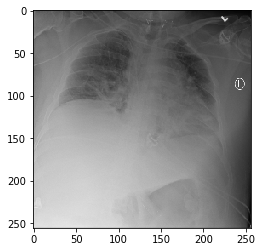

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(img)

In [8]:
img.shape

(256, 256, 3)

In [9]:
train_img = []
for img_name in tqdm(train['image_name'].values):
    train_img.append(read_img(TRAIN_PATH + img_name))

# normalize images
x_train = np.array(train_img, np.float32) / 255.
del train_img

100%|██████████| 18577/18577 [02:39<00:00, 116.47it/s]


In [10]:
x_train.shape

(18577, 256, 256, 3)

In [11]:
# target variable - encoding numeric value
label_list = train['detected'].tolist()
label_numeric = {k: v+1 for v, k in enumerate(set(label_list))}
y_train = [label_numeric[k] for k in label_list]
y_train = np.array(y_train)

In [12]:
from keras import applications
from keras.models import Model
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator


Using TensorFlow backend.


In [13]:
y_train = to_categorical(y_train)

In [14]:
#Transfer learning with VGG16 
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

In [15]:
## set model architechture 
add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dense(256, activation='relu'))
add_model.add(Dense(y_train.shape[1], activation='softmax'))

model = Model(inputs=base_model.input, outputs=add_model(base_model.output))
model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

In [16]:
batch_size = 32 # tune it
epochs = 5 # increase it lb:0.40856(50 epochs), 0.27101 (5 epochs)

train_datagen = ImageDataGenerator(
        rotation_range=30, 
        width_shift_range=0.1,
        height_shift_range=0.1, 
        horizontal_flip=True)
train_datagen.fit(x_train)

In [17]:
history = model.fit_generator(
    train_datagen.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=x_train.shape[0] // batch_size,
    epochs=epochs
)

Epoch 1/5
580/580 [==============================] - 334s - loss: 2.1878 - acc: 0.3045   
Epoch 2/5
580/580 [==============================] - 333s - loss: 2.0957 - acc: 0.3275   
Epoch 3/5
580/580 [==============================] - 333s - loss: 2.0483 - acc: 0.3405   
Epoch 4/5
580/580 [==============================] - 333s - loss: 2.0117 - acc: 0.3569   
Epoch 5/5
580/580 [==============================] - 333s - loss: 1.9851 - acc: 0.3619   


In [18]:
del x_train

In [19]:
test_img = []
for img_name in tqdm(test['image_name'].values):
    test_img.append(read_img(TEST_PATH + img_name))
    
x_test = np.array(test_img, np.float32) / 255.
del test_img

100%|██████████| 12386/12386 [01:48<00:00, 114.16it/s]


In [20]:
## predict test data
predictions = model.predict(x_test)

In [21]:
# get labels
predictions = np.argmax(predictions, axis=1)
rev_y = {v:k for k,v in label_numeric.items()}
pred_labels = [rev_y[k] for k in predictions]

In [22]:
## make submission
sub = pd.DataFrame({'row_id':test.row_id, 'detected':pred_labels})
sub = sub[['row_id', 'detected']]
filename = 'sub_vgg.csv'
sub.to_csv(filename, index=False) ## lb:0.40856(50 epochs), 0.27101 (5 epochs)
sub.head()

,row_id,detected
0,id_100,class_7
1,id_10002,class_3
2,id_10005,class_3
3,id_10008,class_3
4,id_10009,class_3
